# OpenVaccine: COVID-19 mRNA Vaccine Degradation Prediction

Our team is interested in tackling the OpenVaccine Kaggle competition (https://www.kaggle.com/c/stanford-covid-vaccine) by developing machine learning models to explore the dataset and to predict COVID-19 mRNA vaccine degradation. Train set provides 2400 RNA sequences, and each sequence has three RNA structure features (structure, predicted loop type, base pairing probability) and five ground truths that evaluated through experiments (deg_pH10, deg_Mg_pH10, deg_50C, deg_Mg_50C, reactivity) and their correponding errors. The goal of this competiton is to use RNA structural features to predict the degradation rates at each position of RNA sequences at multiple experimental conditions.

RNA molecules is encoded by four nucleic acids Adenine (A), Guanine (G), Cytosine(C), and Uracil(U). The permutation and combination of the nucleic acids forms three dimentional secondary structures, such as hairpin and loop by pairing themselves through A-U and G-C pairs. The difference in loop types directly affects the degradation rate at each base position. For example, a hairpin will form when multiple bases pair with others forming hydrogen bonds, and become less likely to degrade under challenge conditions such as treatment at pH 10. In the RNA research field, RNA 3D structure is very difficult to be determined experimentally or predict computationally. The features predicted_loop_type and structure in this data set are both predicted through bioinformatics tools; therefore, given the potential errors embedded with the featrues, this may inevitably affect our models and its result. 

The additional challenge in this exercise is the different size of training and testing target. In the 'private' testing dataset, both the feature array length and the output array length is different from the the training data set. Although some of the algorithm we trained permit variable data length, we have decided to focus on the 'public' testing data, which has the same dimension as the training data so we can explore variations of models.

## Initial loading 

### Load Libraries

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import sklearn.metrics as metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split


# Tools for counting letters in the sequences
from collections import Counter as count
import plotly.express as px
import plotly.graph_objects as go


# import tenserflow for neural network models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM, GRU
import tensorflow.keras.layers as layers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy

### Mounting Google Drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load the train data

In [3]:
full_train = pd.read_json('/content/drive/MyDrive/1 MIDS/W207 Applied Machine Learning/Final Project/train.json', lines=True)
full_train = full_train.set_index(keys='index')
full_train.info()
full_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2400 entries, 0 to 2399
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   2400 non-null   object 
 1   sequence             2400 non-null   object 
 2   structure            2400 non-null   object 
 3   predicted_loop_type  2400 non-null   object 
 4   signal_to_noise      2400 non-null   float64
 5   SN_filter            2400 non-null   int64  
 6   seq_length           2400 non-null   int64  
 7   seq_scored           2400 non-null   int64  
 8   reactivity_error     2400 non-null   object 
 9   deg_error_Mg_pH10    2400 non-null   object 
 10  deg_error_pH10       2400 non-null   object 
 11  deg_error_Mg_50C     2400 non-null   object 
 12  deg_error_50C        2400 non-null   object 
 13  reactivity           2400 non-null   object 
 14  deg_Mg_pH10          2400 non-null   object 
 15  deg_pH10             2400 non-null   o

,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
index,,,,,,,,,,,,,,,,,,
0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [4]:
print(full_train.columns)

Index(['id', 'sequence', 'structure', 'predicted_loop_type', 'signal_to_noise',
       'SN_filter', 'seq_length', 'seq_scored', 'reactivity_error',
       'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C',
       'deg_error_50C', 'reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C',
       'deg_50C'],
      dtype='object')


### Load the test data

In [5]:
full_test = pd.read_json('/content/drive/MyDrive/1 MIDS/W207 Applied Machine Learning/Final Project/test.json', lines=True)
full_test = full_test.set_index(keys='index')
full_test.info()
full_test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3634 entries, 0 to 3633
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   3634 non-null   object
 1   sequence             3634 non-null   object
 2   structure            3634 non-null   object
 3   predicted_loop_type  3634 non-null   object
 4   seq_length           3634 non-null   int64 
 5   seq_scored           3634 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 198.7+ KB


,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
index,,,,,,
0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


### Load BPPS files

In [6]:
def load_bpps(df):
  bpps = []
  for seq_id in df.id.to_list():
    bpps.append(np.load(f'/content/drive/MyDrive/1 MIDS/W207 Applied Machine Learning/Final Project/bpps/{seq_id}.npy'))
  return bpps

In [7]:
def bpps_avg(df):
  bpps_arr = []
  for seq_id in df.id.to_list():
    bpps_arr.append(np.load(f'/content/drive/MyDrive/1 MIDS/W207 Applied Machine Learning/Final Project/bpps/{seq_id}.npy').mean(axis=1))
  return bpps_arr

In [8]:
def bpps_full(df):
  bpps_arr = []
  for seq_id in df.id.to_list():
    bpps_arr.append(np.load(f'/content/drive/MyDrive/1 MIDS/W207 Applied Machine Learning/Final Project/bpps/{seq_id}.npy'))
  return bpps_arr

In [9]:
# add bpps data to the full train / test
full_train["bpps_average"] = bpps_avg(full_train)
full_test["bpps_average"] = bpps_avg(full_test)

In [10]:
# add full bpps data to the full train / test
full_train["bpps_full"] = bpps_full(full_train)
full_test["bpps_full"] = bpps_full(full_test)

In [ ]:
full_test.head()

In [ ]:
# export data set to csv to avoid reload bpps file, which takes 30 mins.
# full_train.to_csv("/content/drive/MyDrive/Final Project/full_train_w_bpps.csv")
# full_test.to_csv("/content/drive/MyDrive/Final Project/full_test_w_bpps.csv")

In [ ]:
# #load the file with bpps from google drive
# full_train_w_bpps = pd.read_csv("/content/drive/MyDrive/Final Project/full_train_w_bpps.csv")
# full_test_w_bpps = pd.read_csv("/content/drive/MyDrive/Final Project/full_test_w_bpps.csv")

## EDA

First, we start with sanity check. According to competition description, the test set is a mixture of 'private test' and 'public test' data, differ by the length of RNA sequence (seq_length). Here we separate the test set into two sets. 

In [12]:
public_test = full_test[full_test.seq_length==107].reset_index()
private_test = full_test[full_test.seq_length==130].reset_index()
print(public_test.shape)
print(private_test.shape)

(629, 9)
(3005, 9)


Checking the training data as with quick descrption.


In [ ]:
include =['object', 'float', 'int']
descriptive_summary = full_train.describe(include = include)

descriptive_summary

The data is structured quite complicated with different length for sequences can be different in different data set, so just double check that length is expected. 

In [ ]:
def check_seq_length (data,seq, expected_length):
  return data.apply(lambda x:len(x[seq]) == x[expected_length], axis = 1)

for seq in ['sequence', 'structure', 'predicted_loop_type']: 
  print(f'Is the length for {seq} as expected?', all(check_seq_length(full_train, seq, 'seq_length')))


for seq in ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']: 
  print(f'Is the length for {seq} as expected?', all(check_seq_length(full_train, seq, 'seq_scored')))



In [ ]:
# Function to plot correlation matricies
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

RNA contains four bases and form G-C and A-U paris. COVID-19 mRNA vaccine is single-stranded RNA and it forms pairs as it floats and folds itself. Among the two pair types, G-C pair tends to be more statble than A-U pair due to the bonding strength. Therefore, the higher weight of G and C bases in a RNA will make RNA less degradable. Furthermore, structure and loop type also affects RNA degradation. Unpaired bases are more vulnerable to temperature and UV challenges. Stem stucture tend to be more stable tham loops.
Below, we are exploring the weight of each base in each RNA sequence, weight of possible pairings, and weight of different structure types. 

What is the fraction of each base in each observation? 




In [ ]:
# Count the fraction of all the bases in the sequences
bases = []

for base in range(len(full_train)):
    counts = dict(count(full_train.iloc[base]['sequence']))
    bases.append((
        counts['A'] / 107,
        counts['G'] / 107,
        counts['C'] / 107,
        counts['U'] / 107
    ))
    
bases = pd.DataFrame(bases, columns=['A_percent', 'G_percent', 'C_percent', 'U_percent'])
bases

In [ ]:
include =['object', 'float', 'int']
base_summary = bases.describe(include = include)

base_summary

Of the 4 bases, A has the highest average prevalence while U is the least prevalent on average.

What is fraction of each base pair in each observation? 

In [ ]:
pairs = []
all_partners = []
for base in range(len(full_train)):
  partners = [-1 for symbol in range(130)]
  pairs_dict = {('U', 'G'): 0, ('C', 'G'): 0, ('U', 'A'): 0, ('G', 'C'): 0, ('A', 'U'): 0, ('G', 'U'): 0}
  queue = []
  for symbol in range(0, len(full_train.iloc[base]['structure'])):
    if full_train.iloc[base]['structure'][symbol] == '(':
      queue.append(symbol)
    if full_train.iloc[base]['structure'][symbol] == ')':
      first = queue.pop()
      pairs_dict[(full_train.iloc[base]['sequence'][first], full_train.iloc[base]['sequence'][symbol])] += 1
      partners[first] = symbol
      partners[symbol] = first
  
  all_partners.append(partners)
  
  pairs_num = 0
  pairs_unique = [('U', 'G'), ('C', 'G'), ('U', 'A'), ('G', 'C'), ('A', 'U'), ('G', 'U')]
  for item in pairs_dict:
    pairs_num += pairs_dict[item]
  add_tuple = list()
  for item in pairs_unique:
    add_tuple.append(pairs_dict[item]/pairs_num)
  pairs.append(add_tuple)
    
pairs = pd.DataFrame(pairs, columns=['U-G', 'C-G', 'U-A', 'G-C', 'A-U', 'G-U'])
full_train['partners'] = all_partners
pairs

In [ ]:
include =['object', 'float', 'int']
pair_summary = pairs.describe(include = include)

pair_summary

Looking at the base pairs, on average, the G-C pair is the most prevalent while the U-G pair is the least

What are the total counts of base pairs in the whole training set?

In [ ]:
pairs_dict = {('U', 'G'): 0, ('C', 'G'): 0, ('U', 'A'): 0, ('G', 'C'): 0, ('A', 'U'): 0, ('G', 'U'): 0}
queue = []
for base in range(len(full_train)):
  observation = full_train.iloc[base]
  for symbol in range(len(observation['structure'])):
    if observation['structure'][symbol] == '(':
      queue.append(symbol)
    if observation['structure'][symbol] == ')':
      first = queue.pop()
      pairs_dict[(observation['sequence'][first], observation['sequence'][symbol])] += 1

                
pairs_dict

In [ ]:
names = []
values = []
for item in pairs_dict:
    names.append(item)
    values.append(pairs_dict[item])
    
df = pd.DataFrame()
df['pair'] = names
df['count'] = values
df['pair'] = df['pair'].astype(str)

fig = px.bar(
    df, 
    x='pair', 
    y="count", 
    orientation='v', 
    title='Pair types', 
    height=400, 
    width=800
)
fig.show()

In the predicted loop type column, the following symbols were used to represent
base pair categories.

S: paired "Stem"

M: Multiloop

I: Internal loop 

B: Bulge

H: Hairpin loop 

E: dangling End 

X: eXternal loop 

What is the fraction of each category in each observation?

In [ ]:
loops = []
for prediction in range(len(full_train)):
    counts = dict(count(full_train.iloc[prediction]['predicted_loop_type']))
    types = ['E', 'S', 'H', 'B', 'X', 'I', 'M']
    row = []
    for item in types:
      if item in counts:
        row.append(counts[item] / 107)
      else:
        row.append(0)
    loops.append(row)
    
loops = pd.DataFrame(loops, columns=types)
loops

Looking at the loop type summaries, on average, S is the most prevalent type at 44.21% and B is the least present at 1.12%.

In [ ]:
include =['object', 'float', 'int']
loops_summary = loops.describe(include = include)

loops_summary

In [ ]:
res_dict = {'E':0, 'S':0, 'H':0, 'B':0, 'X':0, 'I':0, 'M':0}
for prediction in range(len(full_train)):
    observation = full_train.iloc[prediction]
    pred_symbol = dict(count(observation['predicted_loop_type']))
    for item in pred_symbol:
      if item in pred_symbol:
        res_dict[item] += pred_symbol[item]

res_dict

In [ ]:
names = []
values = []
for item in res_dict:
    names.append(item)
    values.append(res_dict[item])
    
df = pd.DataFrame()
df['loop_type'] = names
df['count'] = values

In [ ]:
fig = px.bar(
    df, 
    x='loop_type', 
    y="count", 
    orientation='v', 
    title='Predicted loop types', 
    height=400, 
    width=600
)
fig.show()

In [ ]:
#pairs and loops
pairs.reset_index(drop=True, inplace=True)
loops.reset_index(drop=True, inplace=True)

correlation_frame = pd.concat([pairs, loops], axis=1)
correlation_frame

g = sns.PairGrid(correlation_frame, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.histplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)

Looking at correlations between base pairs and loop types, we see a high correlation of -.82 between loop types E and S. It looks like there may be an strong grouping of data anchoring this relationship. There is also a strong inverse relationship of -.60 between U-A and G-C pairs.

Signal to noise ratio exploration

In [ ]:
fig = px.histogram(
    full_train, 
    "signal_to_noise", 
    nbins=25, 
    title='signal_to_noise histogram', 
    width=700,
    height=500
)
fig.show()

In [ ]:
ds = full_train['SN_filter'].value_counts().reset_index()
ds.columns = ['SN_filter', 'count']
fig = px.pie(
    ds, 
    values='count', 
    names="SN_filter", 
    title='SN_filter pie chart', 
    width=500, 
    height=500
)
fig.show()

Looking for correlation in the means of the prediction targets showed us correlation among the observations/samples. For example, observations with a higher mean deg_50_Mg_50C had a higher mean deg_ph10. The high degree of dimensionality of the target/output variables means that we'll need to employ modeling techquiques that can handle prediction of multiple outputs.



In [ ]:
full_train['mean_reactivity'] = full_train['reactivity'].apply(lambda x: np.mean(x))
full_train['mean_deg_Mg_pH10'] = full_train['deg_Mg_pH10'].apply(lambda x: np.mean(x))
full_train['mean_deg_Mg_50C'] = full_train['deg_Mg_50C'].apply(lambda x: np.mean(x))
full_train['mean_deg_pH10'] = full_train['deg_pH10'].apply(lambda x: np.mean(x))
full_train['mean_deg_50C'] = full_train['deg_50C'].apply(lambda x: np.mean(x))

full_train_plots = full_train.iloc[:,19:25]

full_train_plots

sns.set(style='white', font_scale=1)
g = sns.PairGrid(full_train_plots, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.histplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)

## Data Augmentation 

### Tokenisation

The key input data: sequence, structure and predicted loop type are all given in character (such as "A", '.'), which would be hard for algorithm to consume. Therefore, we tokenise the data and convert it into numerical values. 


In [13]:

# Create an dictionary to map character to a integer
token2int = {x:i for i, x in enumerate('().ACGUBEHIMSX')}

def tokenise(data,  columns = ['sequence','structure', 'predicted_loop_type'], dic = token2int ):

  """
  Function to convert sequence, structure and predited_loop_type into one long numerical 
  feature array for each RNA sample 
  """

  # grab the data 
  temp = list()
  for col in columns:
    temp = temp + list(data[col])
  temp = np.array(temp)

  # creating mapping array 
  k = np.array(list(dic.keys()))
  v = np.array(list(dic.values()))

  # Get argsort indices
  sidx = k.argsort()

  # map the initial array to integers 
  ks = k[sidx]
  vs = v[sidx]
  return vs[np.searchsorted(ks,temp)]

# apply the function to train and test data 
full_train['feature_array'] = full_train.apply(lambda x: tokenise(x, dic = token2int), axis = 1)
full_test['feature_array'] =public_test.apply(lambda x: tokenise(x, dic = token2int), axis = 1)


# tokenise them into separate columns as well 
full_train['token_structure'] = full_train.apply(lambda x: tokenise(x, columns = ['structure']), axis = 1)
full_train['token_looptype'] = full_train.apply(lambda x: tokenise(x, columns = ['predicted_loop_type']), axis = 1)
full_test['token_structure'] = full_test.apply(lambda x: tokenise(x,  columns = ['structure']), axis = 1)
full_test['token_looptype'] = full_test.apply(lambda x: tokenise(x, columns = ['predicted_loop_type']), axis = 1)

In [14]:
# for each sample, pair features of interest into each position
def pair_features(data, features):
  """ Data Engineering function, for each sequence, pair the features of interest to a 1D array, ex [feature1, feature2, feature3]/
  """
  output_df = pd.DataFrame()
  output_df["id"] = data["id"]

  # type the columns to list, only use first 68 positions
  for feature in features:
    output_df[feature] = data[feature].apply(lambda x: list(x)[:68])
  output_df = output_df.set_index(['id']).apply(pd.Series.explode).reset_index()
  output_df["feature_paird"] = output_df[features].values.tolist()
  output = output_df.groupby("id")["feature_paird"].apply(list).reset_index(name='paird_feature')
  return output

In [15]:
# Checking if the shape is as expected 
np.array(full_train['feature_array'].tolist()).shape

(2400, 321)

### Train/ test/ dev split 

We split training data into 80% training, 10% development and 10% test data. So we can evaluate and compare the model before choosing a final model for submission. 

In [ ]:
 # split into a training, a dev and and a test data
train_data, dev_test = train_test_split(
    full_train, test_size=.2, random_state=34, stratify = full_train.SN_filter)
 
dev_data, test_data = train_test_split(
    dev_test, test_size=.5, random_state=34, stratify = dev_test.SN_filter)

dev_data.shape 
train_data.shape

## Evaluation score

The same evaluation score should be used consistently across to assess the model.

In [ ]:
# evaluation score
def MCRMSE(y_true, y_pred):
  if y_true.shape[1:3] == (68,5): 
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=(0, 1))
  elif y_true.shape[1:3] == (5,68): 
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=(0, 2))
  else: 
    raise Exception('Unexpected shape')
  return tf.reduce_mean(tf.sqrt(colwise_mse), axis=-1)

## Baseline model - vanilla neural network

We are chosing a vanilla neural network as a baseline model. The reason for the choice was because of the input data we have. As mentioned in the data augementation section, the main input data was tokenised biological representation of RNA, it would be quite meaningless for some statistical model since the the numbers does not bear any nmerical/ categorical meaning. We think a neural network should be able to handle the complexity inside the problem. General field research and browsing through past submission also proven the choice.

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def build_sklearn_model(input_feature, output_target, model, params,  dev_feature, dev_target):
  """
  Training function to conduct grid search for sklearn package model 
  """    
  # def a grid search for var_smoothing 

  # start a grid search with 5 fold CV
  clf = GridSearchCV(model, params, cv=5, 
                     n_jobs = 2,
                     scoring = 'neg_root_mean_squared_error')
  clf.fit(input_feature, output_target)

  # get the best performing model from grid search 
  clf_best = clf.best_estimator_
  clf_best.fit(input_feature, output_target)
  
  return clf_best

Start tratining the model. We made a concise decision here that to build one single model for all target output. 
1. Given the amount of the data, it was quite computationally and timely consuming to train the model. Having one model for 5 targets could control the overall expense. 
2. Sophisticated model like NN should be able to handle multiple output. 

In [ ]:
# prep feature 
train_feature = np.array(train_data['feature_array'].tolist())
dev_feature = np.array(dev_data['feature_array'].tolist())
test_feature = np.array(test_data['feature_array'].tolist())


# for target in targets: 
  # prep the data
output_target = np.array(train_data[targets].values.tolist()).reshape((1920, 68*5))
dev_target =np.array(dev_data[targets].values.tolist()).reshape((240, 68*5))
test_target = np.array(test_data[targets].values.tolist()).reshape((240, 68*5))

In [ ]:
 np.array(train_data[targets].values.tolist()).shape[1:3] == (5,68)

In [ ]:
# start grid search for all desired outputs
targets = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']


# initiate a single ANN
clf_single = MLPRegressor(max_iter=300, learning_rate = 'adaptive')
       
#def a set of params to use for grid search 
params = {'alpha': [ 0.0001, 0.001, 0.01, 0.1, 1.0, 2.0, 10.0],
          'hidden_layer_sizes': [(100,), (200,), (100, 100), (100, 50, 50, 50)]
          }

  # start grid search
nn_estimator = build_sklearn_model(train_feature, output_target, clf_single, params, dev_feature, dev_target)

# and include prediction
nn_predict = nn_estimator.predict(test_feature)

# # It takes really long time to do the gridsearch, so make some noise when it finish
# import IPython
# display(IPython.display.Audio(url="https://www.soundhelix.com/examples/mp3/SoundHelix-Song-14.mp3", autoplay=True))

In [ ]:
nn_estimator

#### Baseline score

As mentioned, we will use the same metric as the competition is using to evaluate the score, a column wise root mean square error.

In [ ]:
baseline_score = MCRMSE(nn_predict.reshape(240,5,68), test_target.reshape(240,5,68))
print(f'The baseline score is {baseline_score.numpy()}')

#### Baseline prediction result

In [ ]:
# result = pd.DataFrame(dict(zip(targets, nn_predict)), index=test_data.id)
# result.to_csv('/content/drive/MyDrive/1 MIDS/W207 Applied Machine Learning/Final Project/base_line_result.csv')

## Some thoughts on next steps
1. the best performing models in the competition submissions are variants of LSTM, which makes sense as we always want to previous bases in a sequence would matter, should we should take a look
2. the bpps data is worthy exprimenting.
3. the sequence been scored is a shorter set compared to sequence provieded, maybe we can throw away the bottom part to reduce the dimension.
4. more feature engineering, using the base pairs for e.g.
    - explore relationship of base pairs with prediction targets in more granular detail. For example are G bases associated with higher reactivity?
5. Use the competition specific scoring metric to evaluate performance.
6. We used seperate models for 5 output variables, since each output is already non-scalar, we can also try to predict all 5 output with one model.
7. The ANN are suffering from covergence warmings despite a large epoches. We could try other optimisation methods. 

## More model expriment 

### Support Vector Regression

Support vector has been popular to model for none-linear relationship, we would like to expriment the possibility with it. However, SVR by default only output one prediction in each model. Fortunately, given sklearn provides wrappers for multiple outputs so we were still able to expriment. 

In [ ]:

# initiate a single support vector machine. 
svr_single = SVR(kernel = 'sigmoid', tol=0.01)
mor = MultiOutputRegressor(svr_single)
       
#def a set of params to use for grid search 
params = {'estimator__C': [ 0.0001, 0.001, 0.01, 0.1, 1.0, 2.0, 10.0]
          }

# start grid search
svr_estimator = build_sklearn_model(train_feature, output_target, mor, params, dev_feature, dev_target)

# and include prediction
svr_predictions = svr_estimator.predict(test_feature)
# svr_predictions.append(list(target_predict))

# score = np.sqrt(metrics.mean_squared_error(test_target, target_predict))
# svr_scores.append([score])
# print(f'Final SVR model for has RMSE: {score}')


In [ ]:
svr_estimator

In [ ]:
svr_score = MCRMSE(svr_predictions.reshape(240,5,68), test_target.reshape(240,5,68))

print(f'The SVR score is {svr_score.numpy()}')

### Recurrent Neural Network 

Below is a a helper function to train and evaluate tensorflow models. 

In [ ]:
def build_tensorflow_model(x_train, y_train, x_dev, y_dev, x_test, y_test, model, epoch =45):
  """ a helper function to train and evaluate tensorflow models"""
  
  print('Model Summary')
  print(model.summary())
  print('\n \n')
  print('Start training ')

  hist = model.fit(x_train, y_train,  epochs=epoch, verbose = 2, validation_data=(x_dev, y_dev))

  plt.figure(figsize=(8, 6))
  plt.plot(hist.history['loss'], label = "loss")
  plt.plot(hist.history['val_loss'], label = "val_loss")

  plt.xlabel('Epoch')
  plt.ylabel('MCRMSE')
  plt.title('Training Histroy')

  plt.legend()
  # Display a figure.
  plt.show()

  print('Generate prediction')
  predict = model.predict(x_test)
  predicted_score = MCRMSE(predict, y_test)
  print(f'The model testomh prediction score is {predicted_score.numpy()}')

  return model

#### RNN1 - single target

This model only uses the features that derived from sequence but directly related to degradability at RNA positions. Structure and looptype are considered secondary structures. In this model, we are looking at the contributions of above two features and the base pairing probabilities and how they affect the degradation rate at each position synergically through a RNN sequence-to-sequence model. This way we assume that ~3000 RNAs are randomly sampled from  population, and fundamentally we assume all RNA with given features will result in the similar degradation rate in the targeted experimental conditions. 

In [ ]:
features = ["token_structure", "token_looptype", "bpps_average"]
targets = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

x_train_df = pair_features(train_data, features)
x_dev_df = pair_features(dev_data, features)
x_test_df = pair_features(test_data, features)

In [ ]:
# convert to tf object and reshape to 
x_train = tf.convert_to_tensor(np.array(x_train_df['paird_feature'].tolist()).reshape((-1,68,3)))
x_dev = tf.convert_to_tensor(np.array(x_dev_df['paird_feature'].tolist()).reshape((-1,68,3)))
x_test = tf.convert_to_tensor(np.array(x_test_df['paird_feature'].tolist()).reshape((-1,68,3)))

In [ ]:
def gru_layer(hidden_dim, dropout):
    return layers.Bidirectional(layers.GRU(hidden_dim, dropout=dropout, return_sequences=True, kernel_initializer='glorot_uniform'))
def LSTM_layer(hidden_dim, dropout):
    return layers.Bidirectional(layers.LSTM(hidden_dim, dropout=dropout, return_sequences=True, kernel_initializer='glorot_uniform'))

# Modeling
model6 = Sequential()
model6.add(layers.Input(shape=(68, 3)))
model6.add(layers.Embedding(input_dim=len(x_train)+1, output_dim=1))
model6.add(layers.Reshape(target_shape=(68,3)))
model6.add(layers.SpatialDropout1D(rate=0.2))
model6.add(LSTM_layer(hidden_dim=256, dropout=0.2))
model6.add(gru_layer(hidden_dim=256, dropout=0.2))
model6.add(layers.Dense(1, activation='sigmoid'))
model6.compile(optimizer="Adam", loss=MCRMSE, metrics=["mse"])

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
for label in targets:
  y_train = tf.convert_to_tensor(np.array(train_data[label].tolist()).reshape((-1,68,1)))
  y_dev = tf.convert_to_tensor(np.array(dev_data[label].tolist()).reshape((-1,68,1)))
  y_test = tf.convert_to_tensor(np.array(test_data[label].tolist()).reshape((-1,68,1)))
  print("Target: " + label + ": \n")
  build_tensorflow_model(x_train, y_train, x_dev, y_dev, x_test, y_test, model6, epoch = 15)

### More RNN - multiple targets



#### RNN2 
The thoughts here is that a large amount of bpps data was derived from the sequence/ loop type/ structure data. Since they are derived data, We want to expriment repoducing those from sequences with neural networks. Therefore, we will add multiple middle layers first to generate more data, potentially to mimic the other data that are provided, and then extract the information from it. We again want to use RNN given the sequential nature of the data. 


In [ ]:
# convert to tf object
train_sequence = tf.convert_to_tensor(np.array(train_data['feature_array'].tolist()).reshape((-1,1,321)))
dev_sequence = tf.convert_to_tensor(np.array(dev_data['feature_array'].tolist()).reshape((-1,1,321)))
test_sequence = tf.convert_to_tensor(np.array(test_data['feature_array'].tolist()).reshape((-1,1,321)))

In [ ]:
# prepare train/dev label (y)
y_train_all = tf.convert_to_tensor(np.array(train_data[targets].values.tolist()))
y_dev_all = tf.convert_to_tensor(np.array(dev_data[targets].values.tolist()))
y_test_all = tf.convert_to_tensor(np.array(test_data[targets].values.tolist()))

In [ ]:
# Initialising a model 
model2 = Sequential()

# using Embedding as first layer since all 
model2.add(layers.Embedding(len(token2int)+1, 1, input_shape = (1, 321)))
model2.add(layers.Reshape((1,321)))
# Recurrent layer, using a GRU since it is cheaper 
model2.add(layers.GRU(321, return_sequences=True, recurrent_dropout=0.05))
# # The choice of the recurrent unit is 68*68, same size the bpps file size for each sample 
model2.add(Dense(4624, activation='sigmoid'))
model2.add(Dropout(0.05, seed = 34))

model2.add(layers.Conv1D(2312, 1, activation='linear', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='glorot_uniform'))
# Some fully connected layer
model2.add(Dense(1024, activation='sigmoid'))
model2.add(layers.MaxPooling1D(1,1))
model2.add(Dense(512, activation='sigmoid'))
model2.add(layers.LSTM(340, dropout=0.05, recurrent_dropout=0.05,))
model2.add(layers.Reshape((5,68)))
model2.add(Dense(68, activation='relu'))

# Output layer
model2.add(Dense(68, activation='sigmoid'))


# Compile the model
opt = SGD(momentum=0.9)
# Use the loss function by the scoring method 
model2.compile(optimizer=opt, loss=MCRMSE, metrics=["mse"])

In [ ]:
model2 = build_tensorflow_model(train_sequence, y_train_all, dev_sequence, y_dev_all, test_sequence, y_test_all, model2)

In [ ]:
# print(model2.summary())

In [ ]:
# model2.fit(train_sequence, y_train_all,  epochs=30,  validation_data=(dev_sequence, y_test_all))

In [ ]:
# model2_predict = model2.predict(test_sequence)
# MCRMSE(model2_predict, y_test_all)

#### RNN3

In [ ]:
# Initialising a model 
model3 = Sequential()

# using Embedding as first layer since all 
model3.add(layers.Embedding(len(token2int)+1, 1, input_shape = (1, 321)))
model3.add(layers.Reshape((1,321)))
# Recurrent layer, using a GRU since it is cheaper 
model3.add(layers.GRU(512, return_sequences=True, recurrent_dropout=0.05))
# # The choice of the recurrent unit is 68*68, same size the bpps file size for each sample 
model3.add(Dropout(0.05, seed = 34))

# model3.add(layers.Conv1D(512, 1, activation='linear', 
#                   kernel_initializer='glorot_uniform',
#                   bias_initializer='glorot_uniform'))
# Some fully connected layer
# model3.add(Dense(512, activation='sigmoid'))
# model3.add(layers.MaxPooling1D(1,1))
model3.add(layers.LSTM(340, dropout=0.05, recurrent_dropout=0.05,))
model3.add(layers.Reshape((5,68)))

# Output layer
model3.add(Dense(68, activation='linear'))
model3.add(Dense(68, activation='tanh'))


# Compile the model
opt = SGD(momentum=0.9)
# Use the loss function by the scoring method 
model3.compile(optimizer=opt, loss=MCRMSE, metrics=["mse"])

In [ ]:
model3 = build_tensorflow_model(train_sequence, y_train_all, dev_sequence, y_dev_all, test_sequence, y_test_all, model3)

#### RNN4


In [ ]:
# Initialising a model 
model4 = Sequential()

# using Embedding as first layer since all 
model4.add(layers.Embedding(len(token2int)+1, 1, input_shape = (1, 321)))
model4.add(layers.Reshape((1,321)))
model4.add(Dropout(0.05, seed = 34))
# Recurrent layer, using a GRU since it is cheaper 
model4.add(layers.Bidirectional(layers.GRU(107, return_sequences=True, recurrent_dropout=0.05)))
model4.add(layers.Bidirectional(layers.GRU(107, return_sequences=True, recurrent_dropout=0.05)))

# # The choice of the recurrent unit is 68*68, same size the bpps file size for each sample 
model4.add(Dropout(0.05, seed = 34))

# Some fully connected layer
model4.add(layers.Bidirectional(layers.LSTM(340, dropout=0.05, recurrent_dropout=0.05,)))
# model4.add(layers.Bidirectional(layers.LSTM(340, dropout=0.05, recurrent_dropout=0.05,)))
model4.add(Dense(340, activation='sigmoid'))
model4.add(layers.Reshape((5,68)))

# # Output layer
model4.add(Dense(68, activation='linear'))


# Compile the model
opt = SGD(momentum=0.9)
# Use the loss function by the scoring method 
model4.compile(optimizer=opt, loss=MCRMSE, metrics=["mse"])

In [ ]:
model4 = build_tensorflow_model(train_sequence, y_train_all, dev_sequence, y_dev_all, test_sequence, y_test_all, model4)

In [ ]:
# model4.fit(train_sequence, y_train_all,  epochs=75,  validation_data=(dev_sequence, y_dev_all))

In [ ]:
# model4_predict = model4.predict(test_sequence)
# MCRMSE(model4_predict, y_test_all)

#### RNN5


In [ ]:
train_sequence2 = tf.convert_to_tensor( np.array(train_data['feature_array'].tolist()).reshape((-1,3,107)).swapaxes(1,2))
dev_sequence2 = tf.convert_to_tensor(np.array(dev_data['feature_array'].tolist()).reshape((-1,3,107)).swapaxes(1,2))
test_sequence2 = tf.convert_to_tensor( np.array(test_data['feature_array'].tolist()).reshape((-1,3,107)).swapaxes(1,2))

In [ ]:
y_train_all2 = tf.convert_to_tensor(np.array(train_data[targets].values.tolist()).swapaxes(1,2))
y_dev_all2 = tf.convert_to_tensor(np.array(dev_data[targets].values.tolist()).swapaxes(1,2))
y_test_all2 = tf.convert_to_tensor(np.array(test_data[targets].values.tolist()).swapaxes(1,2))

In [ ]:
# Initialising a model 

inputs = layers.Input(shape=(107, 3))

# using Embedding as first layer since all 
embed = layers.Embedding(len(token2int), 200) (inputs)
embed = layers.Reshape((107,600))(embed)
# Recurrent layer, using a GRU since it is cheaper 
hidden = layers.SpatialDropout1D(0.05, seed = 34)(embed)


hidden = layers.Bidirectional(layers.GRU(321, return_sequences=True, recurrent_dropout=0.05))(embed)

# # The choice of the recurrent unit is 68*68, same size the bpps file size for each sample 
hidden = layers.SpatialDropout1D(0.05, seed = 34)(hidden)

# # Some fully connected layer
hidden = layers.Bidirectional(layers.GRU(256, return_sequences=True, recurrent_dropout=0.05,kernel_initializer='orthogonal'))(hidden)

hidden = hidden[:, :68]

hidden = layers.Dense(60, activation='sigmoid')(hidden)

# # # # # Output layer
out = layers.Dense(5, activation='linear')(hidden)


model5 = tf.keras.Model(inputs=inputs, outputs=out)
model5.compile(tf.optimizers.Adam(), loss=MCRMSE)

In [ ]:
model5 = build_tensorflow_model(train_sequence2, y_train_all2, dev_sequence2, y_dev_all2, test_sequence2, y_test_all2, model5,epoch=25)

In [ ]:
inputs = layers.Input(shape=(107, 3))

# using Embedding as first layer since all 
embed = layers.Embedding(len(token2int), 200) (inputs)
embed = layers.Reshape((107,600))(embed)
# Recurrent layer, using a GRU since it is cheaper 
hidden = layers.SpatialDropout1D(0.05, seed = 34)(embed)


hidden = layers.Bidirectional(layers.GRU(321, return_sequences=True, recurrent_dropout=0.05))(embed)

# # The choice of the recurrent unit is 68*68, same size the bpps file size for each sample 
hidden = layers.SpatialDropout1D(0.05, seed = 34)(hidden)

# # Some fully connected layer
hidden = layers.Bidirectional(layers.LSTM(256, return_sequences=True, recurrent_dropout=0.05,kernel_initializer='orthogonal'))(hidden)
hidden = layers.Bidirectional(layers.LSTM(256, return_sequences=True, recurrent_dropout=0.05,kernel_initializer='orthogonal'))(hidden)

hidden = hidden[:, :68]

hidden = layers.Dense(60, activation='sigmoid')(hidden)

# # # # # Output layer
out = layers.Dense(5, activation='linear')(hidden)


model6 = tf.keras.Model(inputs=inputs, outputs=out)
model6.compile(tf.optimizers.Adam(), loss=MCRMSE)

In [ ]:
model6 = build_tensorflow_model(train_sequence2, y_train_all2, dev_sequence2, y_dev_all2, test_sequence2, y_test_all2, model6,epoch=40)

## Exploratory unsupervised learning

The datasets contain at least 107 different potential features over at least 3 different categories. The more raw BPPS data contains 107*107 features. As the dimensionality of this data is so high, we chose to see if there was value in reducing the dimensionality of the data for use in more interpretable models like k-means, knn, gmm, regression.

We started by dimensionally reducing the tokenized data and saw that PCA dimension reduction did not seem to explain the variance in the data, implying a low degree of redundancy in the features.

The fraction of the total variance in the train data explained by 1  component(s) is 0.038
The fraction of the total variance in the train data explained by 2  component(s) is 0.031
The fraction of the total variance in the train data explained by 3  component(s) is 0.027
The fraction of the total variance in the train data explained by 4  component(s) is 0.024
The fraction of the total variance in the train data explained by 5  component(s) is 0.022
The fraction of the total variance in the train data explained by 10  component(s) is 0.017
The fraction of the total variance in the train data explained by 20  component(s) is 0.009
The fraction of the total variance in the train data explained by 30  component(s) is 0.006
The fraction of the total variance in the train data explained by 40  component(s) is 0.005
The fraction of the total variance in the train data explained by 50  component(s) is 0.004


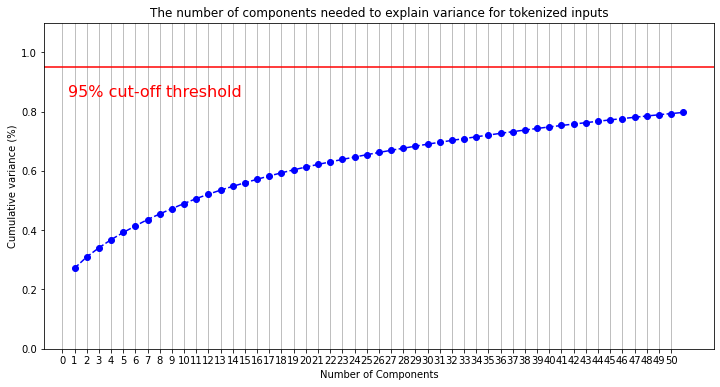

In [33]:
# PCA on tokenized inputs feature array
features_token = np.array(full_train['feature_array'].values.tolist()).reshape((2400, 321))
# Initialize PCA
pca = PCA(n_components=51)
# Fit PCA
principalComponents = pca.fit_transform(features_token)
# Create data frame of principal components
principalDf = pd.DataFrame(data = principalComponents)
# Create array of varaciance explained by each factor
variance_explained = pca.explained_variance_ratio_
# display(variance_explained)
# Iniitalize sensitivity analysis for different numbers of factors
k = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]
for component in k:
  print("The fraction of the total variance in the train data explained by",component, " component(s) is",round(variance_explained[component],3))

# display(principalDf)
# Plot number of principal components vs. cumulative variance explaiend
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi_token = np.arange(1, 52, step=1)
y_token = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi_token, y_token, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 51, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance for tokenized inputs')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

So we decided to add more features to look for more explanatory power. We averaged the BPPS data.

The fraction of the total variance in the train data explained by 1  component(s) is 0.075
The fraction of the total variance in the train data explained by 2  component(s) is 0.034
The fraction of the total variance in the train data explained by 3  component(s) is 0.032
The fraction of the total variance in the train data explained by 4  component(s) is 0.024
The fraction of the total variance in the train data explained by 5  component(s) is 0.023
The fraction of the total variance in the train data explained by 10  component(s) is 0.016
The fraction of the total variance in the train data explained by 20  component(s) is 0.01
The fraction of the total variance in the train data explained by 30  component(s) is 0.008
The fraction of the total variance in the train data explained by 40  component(s) is 0.006
The fraction of the total variance in the train data explained by 50  component(s) is 0.005


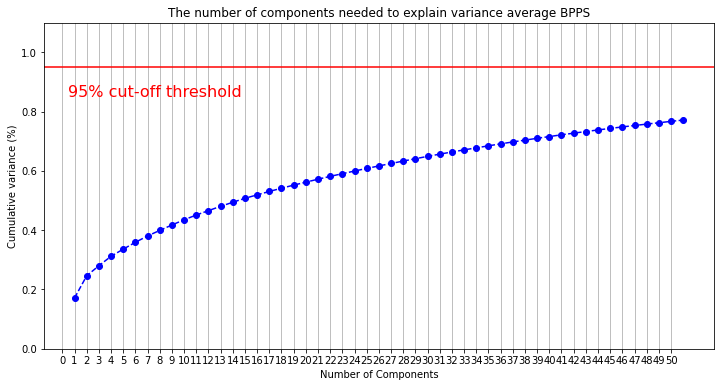

In [34]:
# PCA on Average BPPS data
# display(full_train)

# Create an array of just the average bpps values
bpps_avg_pca = np.array(full_train['feature_array'].values.tolist()).reshape((2400, 321))
# Scale bpps_avg values between 0 and 1
bpps_avg_pca_scaled = StandardScaler().fit_transform(bpps_avg_pca)
# display(bpps_avg_pca)
# print(len(bpps_avg_pca))
# Initialize PCA
pca = PCA(n_components=51)
# Fit PCA
principalComponents = pca.fit_transform(bpps_avg_pca_scaled)
# Create data frame of principal components
principalDf = pd.DataFrame(data = principalComponents)
# Create array of varaciance explained by each factor
variance_explained = pca.explained_variance_ratio_
# display(variance_explained)
# Iniitalize sensitivity analysis for different numbers of factors
k = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]
for component in k:
  print("The fraction of the total variance in the train data explained by",component, " component(s) is",round(variance_explained[component],3))

# display(principalDf)
# Plot number of principal components vs. cumulative variance explaiend
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi_avg = np.arange(1, 52, step=1)
y_avg = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi_avg, y_avg, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 51, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance average BPPS')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

That didn't seems to help, so we ran PCA on the raw 107*107 BPPS file and did not see an improvement in variance explainability. This implies that the input data has high dimensionality.

The fraction of the total variance in the train data explained by 1  component(s) is 0.048
The fraction of the total variance in the train data explained by 2  component(s) is 0.046
The fraction of the total variance in the train data explained by 3  component(s) is 0.038
The fraction of the total variance in the train data explained by 4  component(s) is 0.035
The fraction of the total variance in the train data explained by 5  component(s) is 0.03
The fraction of the total variance in the train data explained by 10  component(s) is 0.014
The fraction of the total variance in the train data explained by 20  component(s) is 0.008
The fraction of the total variance in the train data explained by 30  component(s) is 0.006
The fraction of the total variance in the train data explained by 40  component(s) is 0.005
The fraction of the total variance in the train data explained by 50  component(s) is 0.004


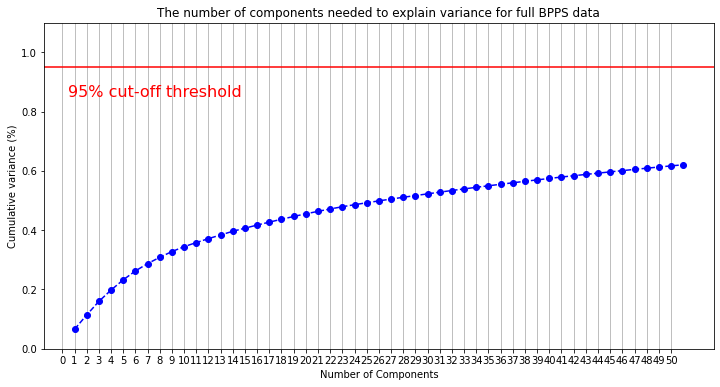

In [35]:
# Create a dataframe by reshaping the raw, full BPPS data
single = np.array(full_train['bpps_full'].values.tolist()).reshape((2400, 107*107))
single_df = pd.DataFrame(single)

# Initialize PCA
pca = PCA(n_components=51)
# Fit PCA
principalComponents = pca.fit_transform(single)
# Create data frame of principal components
principalDf = pd.DataFrame(data = principalComponents)
# Create array of varaciance explained by each factor
variance_explained = pca.explained_variance_ratio_
# display(variance_explained)
# Iniitalize sensitivity analysis for different numbers of factors
k = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]
for component in k:
  print("The fraction of the total variance in the train data explained by",component, " component(s) is",round(variance_explained[component],3))

# display(principalDf)
# Plot number of principal components vs. cumulative variance explaiend
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi_full = np.arange(1, 52, step=1)
y_full = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi_full, y_full, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 51, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance for full BPPS data')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

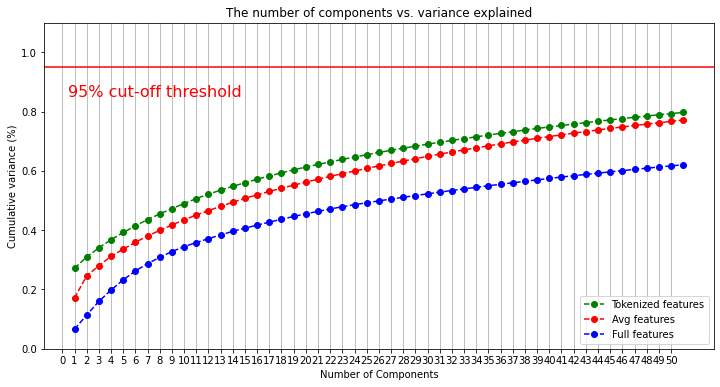

In [42]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()

plt.ylim(0.0,1.1)
plt.plot(xi_token, y_token, marker='o', linestyle='--', color='g', label = "Tokenized features")
plt.plot(xi_avg, y_avg, marker='o', linestyle='--', color='r', label = "Avg features")
plt.plot(xi_full, y_full, marker='o', linestyle='--', color='b', label = "Full features")



plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 51, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components vs. variance explained')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

plt.legend()

ax.grid(axis='x')
plt.show()

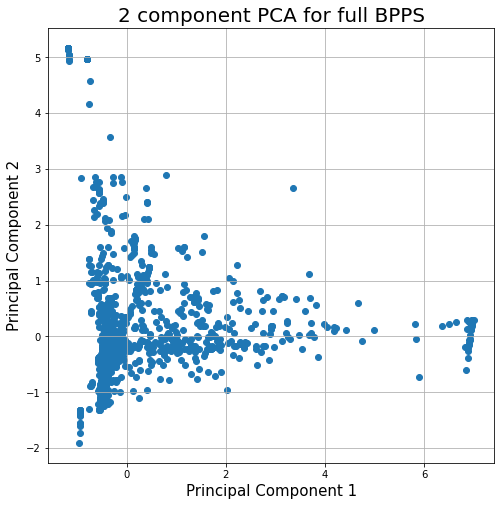

In [21]:
# Initialize PCA w/ 2 components on full BPPS
pca = PCA(n_components=50)
# Fit PCA
principalComponents = pca.fit_transform(single)
# Create data frame of principal components
principalDf = pd.DataFrame(data = principalComponents)
# Create data frame of train label
# train_df = pd.DataFrame(train_labels, columns = ["target"])
# Concatenate train labels with PCs
# finalDf = pd.concat([principalDf, train_df], axis = 1)
# display(finalDf)

# Plot principal componet 1 vs. 2 and display poison vs. non-poison
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA for full BPPS', fontsize = 20)
ax.scatter(principalDf[0], principalDf[1])
# targets = [1, 0]
# colors = ['r', 'g']
# for target, color in zip(targets,colors):
#     indicesToKeep = finalDf['target'] == target
#     ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
#               , finalDf.loc[indicesToKeep, 'principal component 2']
#               , c = color
#               , s = 50)
# mylabels = ('poisonous','non-poisonous')
# ax.legend(labels=mylabels)
ax.grid()

By visualizaing the clusters generated by k-means, we were looking for groupings, but really didn't find any.

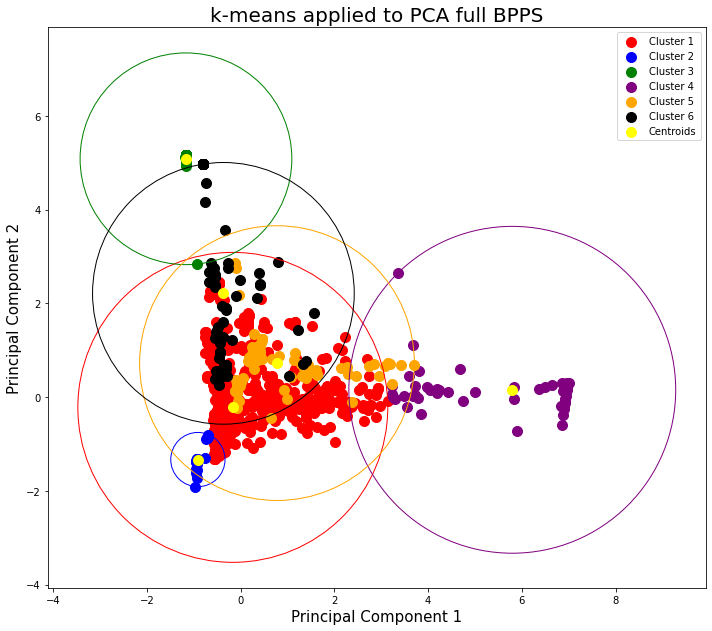

In [45]:
# Initalize K-means for full BPPS
kmeans_pca = KMeans(n_clusters = 6, init = 'k-means++', random_state = 42)
# Fit k-means
kmeans_pca_fit = kmeans_pca.fit(principalComponents)
kmeans_pca_fit_predict = kmeans_pca.fit_predict(principalComponents)

# display(kmeans_pca.labels_)

# Create data frame of clusters
k_clusters_array = kmeans_pca.labels_
k_clusters = pd.DataFrame(kmeans_pca.labels_, columns = ["clusters"])

# train_df = pd.DataFrame(train_labels, columns = ["target"])
# clustered_pca = pd.concat([principalDf, k_clusters, train_df], axis=1)
# display(clustered_pca)

# Initialize dictionaries for centroids

clusters_centroids=dict()
clusters_radii= dict()

# loop over clusters and calculate  distance of 
# each point within that cluster from its centroid and 
# pick the maximum which is the radius of that cluster
# display(principalComponents)
# display(set(k_clusters_array))
# display(kmeans_pca_fit_predict)
for cluster in list(set(k_clusters_array)):      
    # print(cluster)
    clusters_centroids[cluster]=list(zip(kmeans_pca.cluster_centers_[:, 0],kmeans_pca.cluster_centers_[:,1]))[cluster]
    clusters_radii[cluster] = max([np.linalg.norm(np.subtract(i,clusters_centroids[cluster])) for i in zip(principalComponents[kmeans_pca_fit_predict == cluster, 0],principalComponents[kmeans_pca_fit_predict == cluster, 1])])
# display(clusters_centroids)

# Visualize the cluster with centroids and circles

fig, ax = plt.subplots(1,figsize=(10,10))

# Need to set aspect ratio to equal to get plots to come out circular
ax.set_aspect("equal")

# Char labels
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('k-means applied to PCA full BPPS', fontsize = 20)

# Plot clusters and circles
plt.scatter(principalComponents[kmeans_pca_fit_predict == 0, 0], principalComponents[kmeans_pca_fit_predict == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
art = mpatches.Circle(clusters_centroids[0],clusters_radii[0], edgecolor='r',fill=False)
ax.add_patch(art)

plt.scatter(principalComponents[kmeans_pca_fit_predict == 1, 0], principalComponents[kmeans_pca_fit_predict == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
art = mpatches.Circle(clusters_centroids[1],clusters_radii[1], edgecolor='b',fill=False)
ax.add_patch(art)

plt.scatter(principalComponents[kmeans_pca_fit_predict == 2, 0], principalComponents[kmeans_pca_fit_predict == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
art = mpatches.Circle(clusters_centroids[2],clusters_radii[2], edgecolor='g',fill=False)
ax.add_patch(art)

plt.scatter(principalComponents[kmeans_pca_fit_predict == 3, 0], principalComponents[kmeans_pca_fit_predict == 3, 1], s = 100, c = 'purple', label = 'Cluster 4')
art = mpatches.Circle(clusters_centroids[3],clusters_radii[3], edgecolor='purple',fill=False)
ax.add_patch(art)

plt.scatter(principalComponents[kmeans_pca_fit_predict == 4, 0], principalComponents[kmeans_pca_fit_predict == 4, 1], s = 100, c = 'orange', label = 'Cluster 5')
art = mpatches.Circle(clusters_centroids[4],clusters_radii[4], edgecolor='orange',fill=False)
ax.add_patch(art)

plt.scatter(principalComponents[kmeans_pca_fit_predict == 5, 0], principalComponents[kmeans_pca_fit_predict == 5, 1], s = 100, c = 'black', label = 'Cluster 6')
art = mpatches.Circle(clusters_centroids[5],clusters_radii[5], edgecolor='black',fill=False)
ax.add_patch(art)

#Plotting the centroids of the clusters
plt.scatter(kmeans_pca.cluster_centers_[:, 0], kmeans_pca.cluster_centers_[:,1], s = 100, c = 'yellow', label = 'Centroids')

plt.legend()
plt.tight_layout()